# Weather Model

## Directions

For this project, you will need to implement a filtering  inference task on an HMM. These are described in Section 15.2 of the text.

Denote the hidden states of the HMM by `S(t)` and the observations (evidence) by `E(t)`. In the weather problem from the HMM Tutorial, X(t) would be either sunny, rainy, or foggy, and `E(t)` is yes or no to indicate if an umbrella was observed. We will use this model with prior probabilities P(sunny) = 0.5, P(rainy) = 0.25, P(foggy) = 0.25. The remaining probilities you need are specified below in the emisssion (`P_emission`) and transition matrices (`P_transition`).

## What you need to do

You will need to fill in the missing implementations of the following functions in the code where specified by the comments (`### YOUR CODE HERE ###`) and answer the questions where indicated.

In implementing the code for the filtering task, you will be computing the probability of rain given the observations of the umbrella.

## Probability Definitions
Below you will find:
- `P_init`: The initial probabilities of the weather state, whether sunny (0), rainy (1) or foggy (2) 
- `P_transition`: The transition probabilities or the probability that one weather state one day transitions to another weather state 
- `P_emission`: The 'emission' probabilities or the probabilities that an observation is made, conditioned on the underlying state.

In [1]:
### DO NOT CHANGE ###

import numpy as np

# prior probability on weather states
# P(sunny) = 0.5  P(rainy) = 0.25  P(foggy) = 0.25
P_init = np.array([0.5, 0.25, 0.25])

# states (0=sunny, 1=rainy, 2=foggy)
S = [0, 1, 2]

# transition probabilities P(weather tomorrow|weather today)
#                    tomorrrow
#    today     sunny  rainy  foggy
#    sunny      0.8    0.05   0.15
#    rainy      0.2    0.6    0.2 
#    foggy      0.2    0.3    0.5
P_transition = np.array([ [0.8, 0.05, 0.15], [0.2, 0.6, 0.2], [0.2, 0.3, 0.5] ])

# conditional probabilities of evidence (observations) given weather
#                            sunny  rainy  foggy 
# P(umbrella=no | weather)    0.9    0.2    0.7
# P(umbrella=yes | weather)   0.1    0.8    0.3
P_emission = np.array([ [0.9, 0.2, 0.7], [0.1, 0.8, 0.3] ])

### [Question - State Transitions]
If today is sunny what is the most likely forecast for the next two days if you have no umbrella observations to work with?

In [2]:
print(### YOUR CODE HERE ###
"""It will be Sunny tomorrow as well as day after because if today is sunny, 
there is highest chance of weather being sunny tomorrow (0.8) as per transistion probabilities. 
This logic applies for day after tomorrow as well, thus it will be sunny again"""
) ## please enter your answer in the print statement

It will be Sunny tomorrow as well as day after because if today is sunny, 
there is highest chance of weather being sunny tomorrow (0.8). 
This logic applies for day after tomorrow as well


### [Question - Emission probabilities ]
If on the first day you see no umbrella, what is the probability that it is rainy, foggy or sunny (Hint: remember the importance of overall probability of each state)?

What is the most likely weather (hidden state)?

In [60]:
P_state_day0_given_umbrella = P_emission[0]*P_init # P(Weather|Umbrella) = P(Umbrella|Weather) * P(Weather)/P(Umbrella)
State_names = ["Sunny","Rainy","Foggy"]
P_state_day0_given_umbrella = list(P_state_day0_given_umbrella/sum(P_state_day0_given_umbrella)) #Normalizing it to 1

import pandas as pd

print(pd.DataFrame([P_state_day0_given_umbrella],columns = State_names,index=["Probability if no umbrella seen on 1st day"]))
print("\n\nThe most likely weather on the first day is Sunny (0)") ### Your Code Here) ## please enter your answer in the print statement

                                               Sunny     Rainy     Foggy
Probability if no umbrella seen on 1st day  0.666667  0.074074  0.259259


The most likely weather on the first day is Sunny (0)


### Evidence / observations

Now we will define the observations on each day - whether we observed an umbrella (1) or not (0). 


In [4]:
### DO NOT CHANGE ###

## 0 = no umbrella, 1 = umbrella
E = [0, 0, 0, 1, 0, 0, 1, 1, 0, 1]

## Filtering

*As a reminder*

**Filtering**:
Given observation sequence E(0), E(1), ..., E(T-1), compute P(X(T-1)|E(0), ..., E(T-1)).

So we are computing the probability of the final state given our observations or evidence to date.

We do this with the *Forward Algorithm* (see 15.2 in the text), which requires that we initialize probabilities at the first step using our 'prior' probability values of each underlying state. Then we update probabilities at each step (`Recursion`) using the prior step probabilities and given new evidence. We do this until we reach the end and then compute the total probability of each underlying state at the finel step.

### Recursion (and initialization) function definition

In [9]:
### DO NOT CHANGE ###

# Normalize a probability distribution
def normalize(pdist):
   s = sum(pdist)
   for i in range(0,len(pdist)):
      pdist[i] = pdist[i] / s
   return pdist

DEBUG=True

def init_and_recursion(Obs, S, init_prob, P_emission, P_transition):
  ## a has a "row" for every observation and a "column" for every possible state
  a = np.zeros((len(Obs), len(S)))
  for t in range(0, len(Obs)):
    print(f".. (time {t}) Observation: {Obs[t]}")
    ## probability of a[0,:] is computed by summing over probabilities of all the 
    ## ways we could get to this "path" given where we left off at the previous
    ## time step
    if t == 0:
      ##### Initialization
      for j in range(len(S)):
        #print(f"t={t}, j={j}, S[j]={S[j]}, Obs[t]={Obs[t]}")
        a[t, j] = init_prob[j] * P_emission[Obs[t], S[j]]
        current_state_total_prob = a[t, j]
        print(f".... Probability at state {S[j]}: {current_state_total_prob:.4f} (initial state)")
    else:    
      ## we need to compute a probability for each of the possible states
      for j in range(len(S)): ## for each of the present states
        S_curr = S[j]
        ## we need to sum over all of the previous states to get current state prob
        ## we'll keep track of that probability to sum up here
        current_state_total_prob = 0.0
        for k in range(len(S)): ## for each of the possible previous states
          S_prev = S[k] ## possible previous state that we came from
          if DEBUG:
            print(f"......Transition from state={S_prev} to state={S_curr}")
            print(f"        Calculation: ")
            print(f"        {a[t-1, k]:.2f} * {P_emission[Obs[t], S[j]]:.2f} * {P_transition[S_prev, S_curr]:.2f}")
          current_state_total_prob += a[t-1, k] * P_emission[Obs[t], S[j]] * P_transition[S_prev, S_curr]
        a[t, j] = current_state_total_prob
    a[t,:] = normalize(a[t,:])
    print(f".... State probabilities: {a[t, :]}")
  return a

### Termination function definition

In [35]:
### DO NOT CHANGE ###

def termination(a):
  total_ending_prob = 0
  T = a.shape[0]-1 ## last time point
  for i in range(len(a[T, :])):
    total_ending_prob += a[T, i]
  print(f"\nProbability of each potential state: {a[T]}")

### [Question - Final state]
What is the most likely final state (most likely weather)? How much more likely is the final weather than the other two options?

Use the above recursion and initialization function to compute the most likely state at the end (the filtering problem).

In [19]:
### YOUR CODE HERE ###
Probability_at_t = init_and_recursion(E,S,P_init, P_emission, P_transition)
termination(Probability_at_t)
print("\n\nRain is most likely - "+str(0.59991196/0.14176559)+" times more likely than Sunny, and "+str(0.59991196/0.25832245)+" times more likely than Foggy")

.. (time 0) Observation: 0
.... Probability at state 0: 0.4500 (initial state)
.... Probability at state 1: 0.0500 (initial state)
.... Probability at state 2: 0.1750 (initial state)
.... State probabilities: [0.66666667 0.07407407 0.25925926]
.. (time 1) Observation: 0
......Transition from state=0 to state=0
        Calculation: 
        0.67 * 0.90 * 0.80
......Transition from state=1 to state=0
        Calculation: 
        0.07 * 0.90 * 0.20
......Transition from state=2 to state=0
        Calculation: 
        0.26 * 0.90 * 0.20
......Transition from state=0 to state=1
        Calculation: 
        0.67 * 0.20 * 0.05
......Transition from state=1 to state=1
        Calculation: 
        0.07 * 0.20 * 0.60
......Transition from state=2 to state=1
        Calculation: 
        0.26 * 0.20 * 0.30
......Transition from state=0 to state=2
        Calculation: 
        0.67 * 0.70 * 0.15
......Transition from state=1 to state=2
        Calculation: 
        0.07 * 0.70 * 0.20
......Tra

### [Question - Plot probabilities ]

Use the [PyPlot](https://matplotlib.org/stable/tutorials/introductory/pyplot.html#:~:text=the%20pyplot%20interface.-,Intro%20to%20pyplot,the%20plot%20with%20labels%2C%20etc.) library to plot the transition probabilities over time.

In [20]:
Probability_at_t

array([[0.66666667, 0.07407407, 0.25925926],
       [0.72754491, 0.04191617, 0.23053892],
       [0.75184188, 0.03430323, 0.21385489],
       [0.28193177, 0.42375772, 0.29431051],
       [0.557914  , 0.11977787, 0.32230813],
       [0.67907217, 0.05543917, 0.26548866],
       [0.24110328, 0.46633912, 0.2925576 ],
       [0.08189068, 0.72158412, 0.1965252 ],
       [0.44681054, 0.19767926, 0.3555102 ],
       [0.14176559, 0.59991196, 0.25832245]])

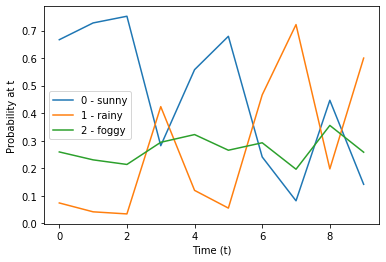

In [34]:
import matplotlib.pyplot as plt

prob_plot = plt.plot(range(0,len(Probability_at_t)),Probability_at_t)

plt.xlabel('Time (t)')
plt.ylabel('Probability at t')

plt.legend(iter(prob_plot),['0 - sunny', '1 - rainy', '2 - foggy'])
plt.show()

The beauty of Filtering as a decision making technique is that it learns from observed data over time and corrects its initial assumption into a data-driven state inference when provided with sensory evidence. This means that an agent powered by a Hidden Markov Model improves over time as it gets more and more data, and makes more and more decisions. This improves its filtering, prediction and smoothing abilities over time.

Another examples of such a Hidden Markov Model is Understanding if your friend is in a good or bad mood. We cannot see mood itself, but we can make inferences about mood based on sensory observations like facial expressions, voice modulation, and other behaviors. 

Hidden Markov Model based decision making is so powerful that an agent can detect (or atleast make decisions on) even abstract features such as human mood.